# Photoelectrode chalcohalide search

In this example, we use SMACT to search for possible element combinations with electron energies suitable for photochemical water splitting. 

* We search only through the elements which have been assinged a Solid State Energy (SSE) according to [Pelatt *et al.*](http://www.ncbi.nlm.nih.gov/pubmed/21861503)
* We search only for ternary (A$_x$B$_y$C$_z$) materials where B = O, S, Se or Te; C = F, Cl, Br, I and 1 ≤ x,y,z ≤ 8.


In [11]:
%load_ext autoreload
%matplotlib inline
import smact
import smact.screening as screening
import csv
from os import path
import itertools
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
import cubehelix
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
matplotlib.rcParams['figure.figsize'] = (25, 18)
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the chemical space for the search
Initially we define all the A elements to consider as those which have an SSE value

In [2]:
considered_elements = []
with open(path.join(smact.data_directory, 'SSE.csv'), 'rU') as f:
    reader = csv.reader(f)
    for row in reader:
        considered_elements.append(row[0])

We define a minimum SSE that the A element must have in order that it lies above the reduction potential for water splitting

In [3]:
SSE_min = -4.5
A_elements = []
for cation in considered_elements:
    A_SSE = smact.Element(cation).SSE
    if A_SSE >= SSE_min:
        A_elements.append(cation)

We define our B and C elements

In [4]:
B_elements = ['O','S','Se','Te']
C_elements = ['F','Cl','Br','I']

## Iterative search
We now screen for possible element combinations and apply various levels of screening:

1. There must exist a charge neutral combination for some stoichiometry where 1 ≤ x,y,z ≤ 8
2. The combination must not contravene the electronegativity rule
3. The predicted band gap must be between 1.5 and 2.5 eV
4. Environmental screening based on HHI$_R$

In [5]:
stoichiometry_limit = 8
BG_max = 2.5
BG_min = 1.5

raw_ion_count = 0
charge_balanced_count = 0
electroneg_OK_count = 0
BG_OK_count = 0

unique_ABCs = []

for i, ele_A in enumerate(A_elements):
    paul_A = smact.Element(ele_A).pauling_eneg
    for ox_A in smact.Element(ele_A).oxidation_states:
        for j, ele_B in enumerate(B_elements):
            paul_B = smact.Element(ele_B).pauling_eneg
            for ox_B in smact.Element(ele_B).oxidation_states:     
                for k, ele_C in enumerate(C_elements):
                    paul_C = smact.Element(ele_C).pauling_eneg
                    for ox_C in smact.Element(ele_C).oxidation_states:
                        
                        raw_ion_count = raw_ion_count + 1
                        elements = [ele_A, ele_B, ele_C]
                        ox_states = [ox_A, ox_B, ox_C]
                        electronegativities = [paul_A, paul_B, paul_C]

                        # Test for charge balance
                        cn_e, cn_r = smact.neutral_ratios(ox_states,threshold = stoichiometry_limit)
                        if cn_e:
                            charge_balanced_count = charge_balanced_count + len(cn_r)
                            
                            # Electronegativity test
                            electroneg_OK = screening.pauling_test(ox_states, electronegativities, elements, threshold = 0.0)
                            if electroneg_OK:
                                electroneg_OK_count = electroneg_OK_count + len(cn_r)
                                
                                # Band gap test
                                SSE_A = smact.Element(ele_A).SSE
                                SSE_B = smact.Element(ele_B).SSE
                                SSE_C = smact.Element(ele_C).SSE
                                BG_1 = abs(SSE_A - SSE_B)
                                BG_2 = abs(SSE_A - SSE_C)
                                if (BG_1 <= BG_max) and (BG_1 >= BG_min):
                                    BG_OK_count = BG_OK_count + len(cn_r)
                                    entry = [elements, SSE_A, SSE_B, BG_1]
                                    if entry not in unique_ABCs:
                                        unique_ABCs.append(entry)
                                elif (BG_2 <= BG_max) and (BG_2 >= BG_min):
                                    BG_OK_count = BG_OK_count + len(cn_r)
                                    entry = [elements, SSE_A, SSE_C, BG_2]
                                    if entry not in unique_ABCs:
                                        unique_ABCs.append(entry)

## View results

In [14]:
print "Total number of ion combinations: \t\t\t\t\t{0:8d}".format(raw_ion_count)
print "Total number of charge neutral combinations: \t\t\t\t{0:8d}".format(charge_balanced_count)
print "Total number after electronegativity criterion applied: \t\t{0:8d}".format(electroneg_OK_count)
print "Total number after band gap criteria applied: \t\t\t\t{0:8d}".format(BG_OK_count)
print "Total number of unique ABC compositions: \t\t\t\t{0:8d}".format(len(unique_ABCs))
for i in unique_ABCs:
    print i

Total number of ion combinations: 					   43076
Total number of charge neutral combinations: 				  149902
Total number after electronegativity criterion applied: 		   51994
Total number after band gap criteria applied: 				    7676
Total number of unique ABC compositions: 				      70
[['B', 'O', 'I'], -4.5, -7.0, 2.5]
[['B', 'S', 'F'], -4.5, -6.4, 1.9000000000000004]
[['B', 'S', 'Cl'], -4.5, -6.4, 1.9000000000000004]
[['B', 'S', 'Br'], -4.5, -6.4, 1.9000000000000004]
[['B', 'S', 'I'], -4.5, -6.4, 1.9000000000000004]
[['B', 'Se', 'F'], -4.5, -6.6, 2.0999999999999996]
[['B', 'Se', 'Cl'], -4.5, -6.6, 2.0999999999999996]
[['B', 'Se', 'Br'], -4.5, -6.6, 2.0999999999999996]
[['B', 'Se', 'I'], -4.5, -6.6, 2.0999999999999996]
[['B', 'Te', 'F'], -4.5, -6.0, 1.5]
[['B', 'Te', 'Cl'], -4.5, -6.0, 1.5]
[['B', 'Te', 'Br'], -4.5, -6.0, 1.5]
[['B', 'Te', 'I'], -4.5, -6.0, 1.5]
[['Ti', 'S', 'F'], -4.2, -6.4, 2.2, 1366.6666666666667]
[['Ti', 'S', 'Cl'], -4.2, -6.4, 2.2, 1366.6666666666667]
[['Ti', 'S',

## Remove boron containing compounds
As these are known to form discrete molecular units e.g. BClSe

In [18]:
boron_free = []
for entry in unique_ABCs:
    if entry[0][0] != 'B':
        boron_free.append(entry)
print "Total number of unique ABC compositions without B: \t\t\t{0:8d}".format(len(boron_free))

Total number of unique ABC compositions without B: 			      57


## Apply HHI_R screening criteria
Finally we assign HHI$_R$ scores to each composition and plot the top 20

In [19]:
for entry in boron_free:
    HHI_r = (smact.Element(entry[0][0]).HHI_R
    + smact.Element(entry[0][1]).HHI_R
    + smact.Element(entry[0][2]).HHI_R)/3
    entry.append(HHI_r)

In [22]:
final_list = []
sorted_list = sorted(boron_free, key=itemgetter(4,0))
for i in range(0,20):
    final_list.append(sorted_list[i])
print final_list[2]

[['Sn', 'S', 'Cl'], -4.4, -6.4, 2.0, 1366.6666666666667, 1366.6666666666667]


## Plot graphs

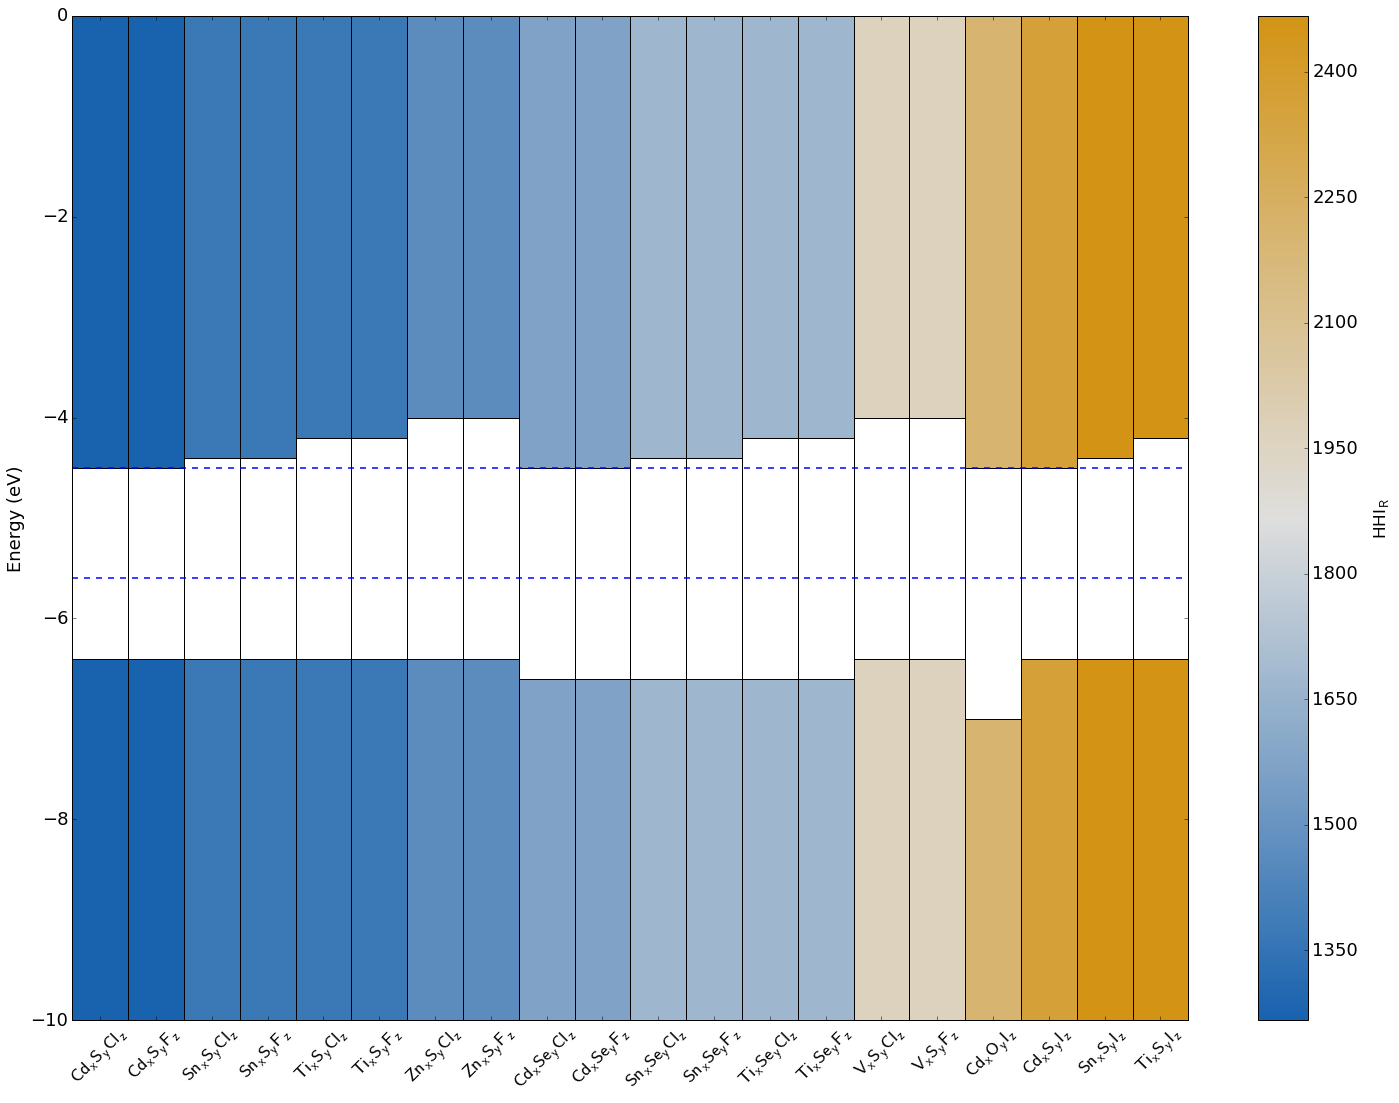

In [23]:
# Labels
labels = []
for i in range(len(final_list)):
    label = r'$\mathrm{\mathsf{%s_x %s_y %s_z}}$' %(final_list[i][0][0],final_list[i][0][1],final_list[i][0][2])
    labels.append(label)
    
# Whole fill bar
fill = []
for i in range(len(final_list)):
    fill.append(-10)

# Lists
HHI_list = []
for i in range(len(final_list)):
    HHI = final_list[i][4]
    HHI_list.append(HHI)

VBM_list = []
for i in range(len(final_list)):
    VBM = final_list[i][2]
    VBM_list.append(VBM)

CBM_list = []
for i in range(len(final_list)):
    CBM = final_list[i][1]
    CBM_list.append(CBM)
    
# Colour
theme_colours = []
with open('colormaps/colormap', 'r') as f:
    for line in f:
        c = line.split()
        theme_colours.append([float(c[0])/256,float(c[1])/256,float(c[2])/256])

col = colors.ListedColormap(theme_colours,name='test')
norm = colors.Normalize(vmin=min(HHI_list), vmax=max(HHI_list), clip = True)
mapper = cm.ScalarMappable(norm=norm, cmap=col)
mapper.set_array(HHI_list)
my_colours = []
for v in HHI_list:
    my_colours.append(mapper.to_rgba(v))    
    
# Horizontal lines
plt.plot([0.,len(final_list)], [-4.5, -4.5], "k--", linewidth = 1.5, color = 'b')
plt.plot([0.,len(final_list)], [-5.6, -5.6], "k--", linewidth = 1.5, color = 'b')

x_pos=np.arange(len(final_list))
plt.bar(x_pos,fill,width=1.0,color=my_colours)
plt.bar(x_pos,VBM_list,width=1.0,color='w')
plt.bar(x_pos,CBM_list,width=1.0,color=my_colours)
plt.xticks(x_pos+0.5, labels, rotation=45)
plt.ylabel('Energy (eV)', size = label_size)

cb = plt.colorbar(mapper)
cb.set_label(r'$\mathrm{\mathsf{HHI_R}}$', size = label_size, labelpad=15)
plt.show()